# Plots for litholog paper

Using the demo data provided in the `litholog` release, this notebook demonstrates data import, plotting and simple statistics of bed thickness and grain size. 

## Import packages

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import litholog
from litholog import utils, Bed, wentworth
from litholog.sequence import io, BedSequence

from striplog import Component

## Import data

In [65]:
# Converts 'string' arrays to numpy
transforms = {c : utils.string2array_matlab for c in ['depth_m', 
                                                      'grain_size_mm']}

# Read the demo data
df = pd.read_csv('../data/demo_data.csv', converters=transforms)

# make a grain size column
df['grain_size_psi'] = df.grain_size_mm.apply(lambda x: np.round(litholog.wentworth.gs2psi(x),4))
df['mean_gs_psi'] = df.mean_gs_mm.apply(lambda x: np.round(litholog.wentworth.gs2psi(x),4))

In [66]:
# Columns shared by whole sequences (i.e., shared by an entire graphic log)
METACOLS = ['name', 'collection', 'ng', 'ar']

# Columns of bed-level data, including the psi column we just made
DATACOLS = ['th', 'gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm','grain_size_psi','mean_gs_psi']

# Convert dataframe to a list of `BedSequence`s
seqs = []
for group, values in df.groupby('name'):
    seqs.append(
        BedSequence.from_dataframe(
            values, 
            thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        )
    )
    
# Show name + eod + number of beds of each
print(len(seqs),'logs imported as BedSequences')

[(s.metadata['name'], len(s),'Beds') for s in seqs]

13 logs imported as BedSequences


[('Karoo krf1', 105, 'Beds'),
 ('Karoo krf2', 20, 'Beds'),
 ('Karoo krf3', 42, 'Beds'),
 ('Karoo krf4', 15, 'Beds'),
 ('Karoo krf5', 51, 'Beds'),
 ('Magnolia', 181, 'Beds'),
 ('Pukearuhue', 211, 'Beds'),
 ('Sierra del Toro dc1', 166, 'Beds'),
 ('Sierra del Toro dc2', 44, 'Beds'),
 ('Sierra del Toro flame', 63, 'Beds'),
 ('Sierra del Toro h2o', 66, 'Beds'),
 ('Sierra del Toro ssm', 54, 'Beds'),
 ('Sierra del Toro wc', 38, 'Beds')]

## Extract data and make plots

### Figure 4
This figure makes a KDE plot of all the sand and mud thickness data 

/var/folders/zs/32ztw4t16_jbynlm7yss2_y00000gn/T/ipykernel_63381/2152457910.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([10**p for p in range(-3, 3)],fontsize=12,rotation=45)


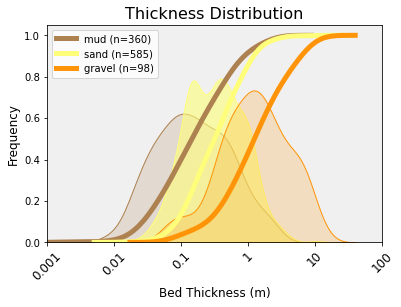

In [33]:
# get some data out of BedSequence using list comprehension
all_gravel_th = [s.get_field('th', lithology='gravel') for s in seqs]
all_sand_th = [s.get_field('th', lithology='sand') for s in seqs]
all_mud_th = [s.get_field('th', lithology='mud') for s in seqs]
all_mud_th[-3]=[] # one log doesn't have any muds, super amalgamated
all_gravel_th[0:7]=[] # lots of logs dont have gravel

# make a quick plot of log10 bed thickness
fig, ax = plt.subplots(figsize=[6,4])
ax.set(facecolor = '#F0F0F0')

sns.kdeplot(np.log10(np.concatenate(all_mud_th, axis=0)),  ax=ax,
            cumulative=False, shade=True, alpha=0.2, color="xkcd:light brown", linewidth=1)
sns.kdeplot(np.log10(np.concatenate(all_sand_th, axis=0)),  ax=ax,
            cumulative=False, shade=True, alpha=0.6, color="xkcd:light yellow", linewidth=1)
sns.kdeplot(np.log10(np.concatenate(all_gravel_th, axis=0)),  ax=ax,
            cumulative=False, shade=True, alpha=0.2, color="xkcd:tangerine", linewidth=1)

sns.kdeplot(np.log10(np.concatenate(all_mud_th, axis=0)),  ax=ax,
            cumulative=True, shade=False, color="xkcd:light brown", linewidth=5, label='mud (n=360)')
sns.kdeplot(np.log10(np.concatenate(all_sand_th, axis=0)), ax=ax,
            cumulative=True, shade=False, color="xkcd:light yellow", linewidth=5, label='sand (n=585)')
sns.kdeplot(np.log10(np.concatenate(all_gravel_th, axis=0)), ax=ax,
            cumulative=True, shade=False, color="xkcd:tangerine", linewidth=5, label='gravel (n=98)')

ax.set_xlabel('Bed Thickness (m)',fontsize=12)
ax.set_xlim(-3, 2)
ax.set_xticklabels([10**p for p in range(-3, 3)],fontsize=12,rotation=45)
ax.set_ylabel('Frequency',fontsize=12)
ax.set_title('Thickness Distribution',fontsize=16)
ax.legend(loc='upper left')

fig.savefig('fig4.svg',format='svg')

## Comparison of Cerro Toro and Skoorsteenberg formations

In [67]:
# subset the BedSequences
krf = seqs[0:4] # krf is for Kleine Reit Fontein, Skoorsteenberg Fm
sdt = seqs[7:12] # sdt is for Sierra del Toro, Cerro Toro Fm

# Get some data out of the BedSequences
sdt_sand_th = [s.get_field('th', lithology='sand') for s in sdt] # list comprehension is the best 
krf_sand_th = [s.get_field('th', lithology='sand') for s in krf]

sdt_mud_th = [s.get_field('th', lithology='mud') for s in sdt]
krf_mud_th = [s.get_field('th', lithology='mud') for s in krf]

sdt_gravel_th = [s.get_field('th', lithology='gravel') for s in sdt]

### Figure 5 - box plot comparing SDT and KRF

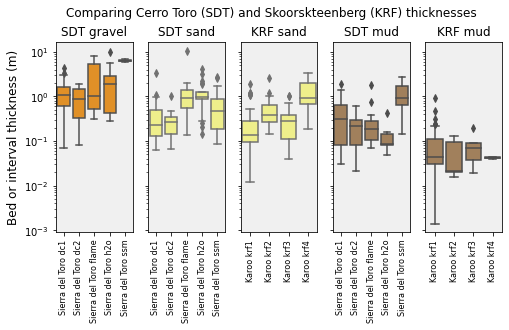

In [46]:
fig, ax = plt.subplots(1,5, figsize=[8,3.5], sharey=True)

for axnum in ax:
    axnum.set(facecolor = '#F0F0F0')

sns.boxplot(data=sdt_gravel_th, ax=ax[0],color='xkcd:tangerine').set_title('SDT gravel')
sns.boxplot(data=sdt_sand_th, ax=ax[1],color='xkcd:light yellow').set_title('SDT sand')
sns.boxplot(data=krf_sand_th, ax=ax[2],color='xkcd:light yellow').set_title('KRF sand')
sns.boxplot(data=sdt_mud_th, ax=ax[3],color='xkcd:light brown').set_title('SDT mud')
sns.boxplot(data=krf_mud_th, ax=ax[4],color='xkcd:light brown').set_title('KRF mud')

for a in ax: a.set_yscale('log')

# make name labels
sdt_names = [s.metadata['name'] for s in sdt]
krf_names = [s.metadata['name'] for s in krf]
ax[0].set_xticklabels(sdt_names,fontsize=8,rotation=90)
ax[1].set_xticklabels(sdt_names,fontsize=8,rotation=90)
ax[2].set_xticklabels(krf_names,fontsize=8,rotation=90)
ax[3].set_xticklabels(sdt_names,fontsize=8,rotation=90)
ax[4].set_xticklabels(krf_names,fontsize=8,rotation=90)

ax[0].set_ylabel('Bed or interval thickness (m)',fontsize=12)

fig.suptitle('Comparing Cerro Toro (SDT) and Skoorskteenberg (KRF) thicknesses',fontsize=12, y=1.02)

fig.savefig('fig5.svg',format='svg')

### Figure 6 KDEs for Cerro Toro

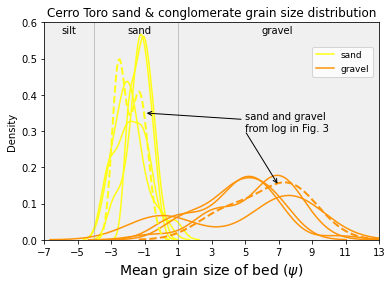

In [112]:
# compare grain size values

fig, ax = plt.subplots(figsize=[6,4])
ax.set(facecolor = '#F0F0F0')

for s in sdt[:-1]:
    sns.kdeplot(s.get_field('mean_gs_psi', lithology='sand'), ax=ax,
                cumulative=False, color="xkcd:yellow", label='sand')
    
for s in sdt[:-1]:
    sns.kdeplot(s.get_field('mean_gs_psi', lithology='gravel'), ax=ax,
                cumulative=False, color="xkcd:tangerine", label='gravel')

# then plot the SSM log with dashed line
sns.kdeplot(sdt[-1].get_field('mean_gs_psi', lithology='sand'), ax=ax,
                cumulative=False, color="xkcd:yellow", linestyle = '--', linewidth=2, label='sand')
sns.kdeplot(sdt[-1].get_field('mean_gs_psi', lithology='gravel'), ax=ax, 
            cumulative=False, color="xkcd:tangerine", linestyle = '--', linewidth=2, label='gravel')
    
#hand, labl = ax.get_legend_handles_labels()
#plt.legend(np.unique(labl))
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
   if l not in lablout:
        lablout.append(l)
        handout.append(h)
#ax.get_legend().remove() # get rid of it first
ax.legend(handout, lablout,loc=[0.8,0.75],fontsize=9) # then add it back

# labels
ax.set_xlabel('Mean grain size of bed ('+r'$\psi$'+')',fontsize=14)
ax.set_xlim(-7, 13)
ax.set_xticks(np.arange(-7,14,2)); # could also use "wentworth.fine_scale" to label these with text labels

ax.axvline(-4,color='xkcd:grey',linewidth=0.5)
ax.axvline(1,color='xkcd:grey',linewidth=0.5)

ax.set_ylim(0,0.6)
ax.text(-6,0.57,'silt')
ax.text(-2,0.57,'sand')
ax.text(6,0.57,'gravel')

ax.annotate("sand and gravel \nfrom log in Fig. 3", xy=(-1, 0.35), xytext=(5, 0.3),arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(7, 0.15), xytext=(5, 0.3),arrowprops=dict(arrowstyle="->"))

ax.set_title('Cerro Toro sand & conglomerate grain size distribution',fontsize=12)

fig.savefig('fig6.svg',format='svg')

### Another plot and KS test for the paper (not used as a fig though)

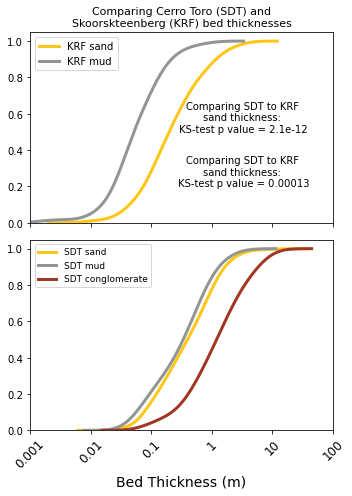

In [7]:
# Now lets concat that list into one big array, then take the log10 of it, then plot it

fig, ax = plt.subplots(2, 1, figsize=[5,7], sharex=True)

sns.kdeplot(np.log10(np.concatenate(krf_sand_th, axis=0)), 
            ax=ax[0], color="xkcd:golden yellow", cumulative=True, linewidth=3, 
            label='KRF sand')
sns.kdeplot(np.log10(np.concatenate(krf_mud_th, axis=0)), 
            ax=ax[0], color="xkcd:grey", cumulative=True, linewidth=3, 
            label='KRF mud')

sns.kdeplot(np.log10(np.concatenate(sdt_sand_th, axis=0)), 
            ax=ax[1], color="xkcd:golden yellow", cumulative=True, linewidth=3, 
            label='SDT sand')

sdt_mud_th[3]=[] # get rid of zero values
sns.kdeplot(np.log10(np.concatenate(sdt_mud_th, axis=0)), 
            ax=ax[1], color="xkcd:grey", cumulative=True, linewidth=3, 
            label='SDT mud')
sns.kdeplot(np.log10(np.concatenate(sdt_gravel_th, axis=0)), 
            ax=ax[1], color="xkcd:brick", cumulative=True, linewidth=3, 
            label='SDT conglomerate');

ax[1].set_xlabel('Bed Thickness (m)',fontsize=14)
ax[1].set_xlim(-3, 2)
ax[1].set_xticks(np.arange(-3,3,1))
ax[1].set_xticklabels([10**p for p in range(-3, 3)],fontsize=12,rotation=45)
ax[1].legend(loc='upper left',fontsize=9)

# KS test
sand_ks_result = stats.ks_2samp(np.log10(np.concatenate(sdt_sand_th, axis=0)),
                           np.log10(np.concatenate(krf_sand_th, axis=0)))
sand_ks_str = 'Comparing SDT to KRF\nsand thickness:\n' + ' KS-test p value = ' + str(sand_ks_result[1].round(5))
ax[0].text(0.5,0.2, sand_ks_str, ha='center')

mud_ks_result = stats.ks_2samp(np.log10(np.concatenate(sdt_mud_th, axis=0)),
                           np.log10(np.concatenate(krf_mud_th, axis=0)))
mud_ks_str = 'Comparing SDT to KRF\nsand thickness:\n' + ' KS-test p value = ' + str(mud_ks_result[1].round(13))
ax[0].text(0.5,0.5, mud_ks_str, ha='center')


ax[0].set_title('Comparing Cerro Toro (SDT) and\nSkoorskteenberg (KRF) bed thicknesses',fontsize=11)

plt.tight_layout()
plt.show()

In [8]:
mud_ks_result

KstestResult(statistic=0.5909251412429378, pvalue=2.0823343049869436e-12)